In [1]:
from __future__ import absolute_import, division, print_function

In [2]:
# License: MIT

# Archetypal analysis of HadISST SST anomalies

This notebook contains results from an archetypal analysis of HadISST SST anomalies.

## Packages

In [82]:
%matplotlib inline

import itertools
from math import pi
import os
import time

import cartopy.crs as ccrs
import cmocean
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import numpy as np
import xarray as xr

from cartopy.util import add_cyclic_point
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import MDS, TSNE

## Analysis parameters

In [4]:
TIME_NAME = 'time'
LAT_NAME = 'latitude'
LON_NAME = 'longitude'
ANOMALY_NAME = 'sst_anom'
STANDARDIZED_ANOMALY_NAME = 'sst_std_anom'

# First and last years to retain for analysis
START_YEAR = 1870
END_YEAR = 2018

# First and last years of climatology base period
BASE_PERIOD_START_YEAR = 1981
BASE_PERIOD_END_YEAR = 2010

# Order of trend removed from anomalies
ANOMALY_TREND_ORDER = 1

# Zonal extents of analysis region
MIN_LATITUDE = -45.5
MAX_LATITUDE = 45.5

# Weighting used for EOFs
LAT_WEIGHTS = 'scos'
RESTRICT_TO_CLIMATOLOGY_BASE_PERIOD = False

# Number of random restarts to use
N_INIT = 100

# If cross-validation is used, number of cross-validation folds
N_FOLDS = 10

# Relaxation parameter for dictionary
DELTA = 0

## File paths

In [9]:
def get_aa_output_filename(input_file, lat_weights, n_components, delta, n_init, cross_validate=False, n_folds=N_FOLDS):
    """Get AA output file corresponding to a given input file."""
    
    basename, ext = os.path.splitext(input_file)
    suffix = 'aa.{}.k{:d}.delta{:5.3e}.n_init{:d}'.format(lat_weights, n_components, delta, n_init)
    if cross_validate:
        suffix = '.'.join([suffix, 'n_folds{:d}'.format(n_folds)])
        
    return '.'.join([basename, suffix]) + ext

In [6]:
PROJECT_DIR = os.path.join(os.getenv('HOME'), 'projects', 'convex-dim-red-expts')
BIN_DIR = os.path.join(PROJECT_DIR, 'bin')
BASE_RESULTS_DIR = os.path.join(PROJECT_DIR, 'results')
RESULTS_DIR = os.path.join(BASE_RESULTS_DIR, 'hadisst', 'nc')
CSV_DIR = os.path.join(BASE_RESULTS_DIR, 'hadisst', 'csv')
PLOTS_DIR = os.path.join(BASE_RESULTS_DIR, 'hadisst', 'plt')

if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)

if not os.path.exists(CSV_DIR):
    os.makedirs(CSV_DIR)

if not os.path.exists(PLOTS_DIR):
    os.makedirs(PLOTS_DIR)

SST_ANOM_INPUT_FILE = os.path.join(RESULTS_DIR, 'HadISST_sst.anom.{:d}_{:d}.trend_order{:d}.nc'.format(
    BASE_PERIOD_START_YEAR, BASE_PERIOD_END_YEAR, ANOMALY_TREND_ORDER))
SST_STD_ANOM_INPUT_FILE = os.path.join(RESULTS_DIR, 'HadISST_sst.std_anom.{:d}_{:d}.trend_order{:d}.nc'.format(
    BASE_PERIOD_START_YEAR, BASE_PERIOD_END_YEAR, ANOMALY_TREND_ORDER))

if not os.path.exists(SST_ANOM_INPUT_FILE):
    raise RuntimeError("Input data file '%s' does not exist" % SST_ANOM_INPUT_FILE)
    
if not os.path.exists(SST_STD_ANOM_INPUT_FILE):
    raise RuntimeError("Input data file '%s' does not exist" % SST_STD_ANOM_INPUT_FILE)

## AA of SST anomalies

As for $k$-means, the archetypes are fitted using the first 90% of the
unstandardized SST anomalies, and the remaining 10% of the data is used to
get a rough estimate of the out-of-sample RMSE.

The optimization if performed for k = 2, ..., 20 archetypes, with random
initial guesses for the archetypes and weights. The fits are performed
using the following script (see bin/run_hadisst_aa.py):

In [7]:
with open(os.path.join(BIN_DIR, 'run_hadisst_aa.py')) as ifs:
    for line in ifs:
        print(line.strip())

"""
Run archetypal analysis on HadISST SST anomalies.
"""

# License: MIT

from __future__ import absolute_import, division, print_function

import argparse
from copy import deepcopy
import time

import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.utils import check_random_state
import xarray as xr

from convex_dim_red import ArchetypalAnalysis


LAT_NAME = 'latitude'
LON_NAME = 'longitude'
TIME_NAME = 'time'
ANOMALY_NAME = 'sst_anom'
STD_ANOMALY_NAME = 'sst_std_anom'

# First and last years to retain for analysis
START_YEAR = 1870
END_YEAR = 2018

# Zonal extents of analysis region
MIN_LATITUDE = -45.5
MAX_LATITUDE = 45.5

LAT_WEIGHTS = 'scos'

# Fraction of data used for assessing out of sample reconstruction error
VALIDATION_FRAC = 0.1

# Number of random restarts to use
INIT = 'random'
N_INIT = 100

# Stopping criteria
MAX_ITERATIONS = 10000
TOLERANCE = 1e-6


def parse_cmd_line_args():
"""Parse command 

In [126]:
max_n_components = 20

sst_k = []
sst_train_cost = []
sst_train_rmse = []
sst_test_cost = []
sst_test_rmse = []

for i in range(1, max_n_components + 1):

    output_file = get_aa_output_filename(SST_ANOM_INPUT_FILE, LAT_WEIGHTS, i, DELTA, N_INIT)
    
    with xr.open_dataset(output_file) as ds:
        
        sst_k.append(ds.sizes['component'])
        sst_train_cost.append(float(ds.attrs['training_set_cost']))
        sst_train_rmse.append(float(ds.attrs['training_set_rmse']))
        sst_test_cost.append(float(ds.attrs['test_set_cost']))
        sst_test_rmse.append(float(ds.attrs['test_set_rmse']))
        
sst_k = np.array(sst_k)
sst_train_cost = np.array(sst_train_cost)
sst_train_rmse = np.array(sst_train_rmse)
sst_test_cost = np.array(sst_test_cost)
sst_test_rmse = np.array(sst_test_rmse)

cost_output_file = 'HadISST_sst.anom.{:d}_{:d}.trend_order{:d}.aa.{}.delta{:5.3e}.n_init{:d}.cost.csv'.format(
    BASE_PERIOD_START_YEAR, BASE_PERIOD_END_YEAR, ANOMALY_TREND_ORDER, LAT_WEIGHTS, DELTA, N_INIT)
cost_output_file = os.path.join(CSV_DIR, cost_output_file)

cost_data = np.zeros((sst_k.shape[0], 5))
cost_data[:, 0] = sst_k
cost_data[:, 1] = sst_train_cost
cost_data[:, 2] = sst_train_rmse
cost_data[:, 3] = sst_test_cost
cost_data[:, 4] = sst_test_rmse

header = 'n_components,training_set_cost,training_set_rmse,test_set_cost,test_set_rmse'
fmt = '%d,%16.8e,%16.8e,%16.8e,%16.8e'

np.savetxt(cost_output_file, cost_data, header=header, fmt=fmt)

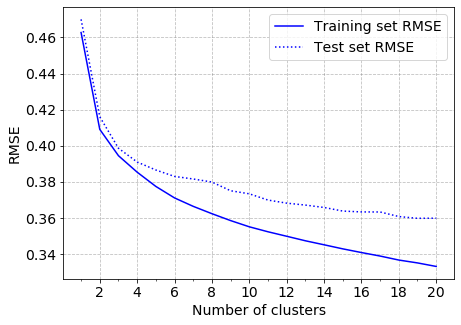

In [127]:
fig = plt.figure(figsize=(7, 5))
ax = plt.gca()

ax.plot(sst_k, sst_train_rmse, 'b-', label='Training set RMSE')
ax.plot(sst_k, sst_test_rmse, 'b:', label='Test set RMSE')

ax.grid(ls='--', color='gray', alpha=0.5)
ax.legend(fontsize=14)

ax.set_xlabel('Number of clusters', fontsize=14)
ax.set_ylabel('RMSE', fontsize=14)

ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.tick_params(labelsize=14)

plt.show()

plt.close()

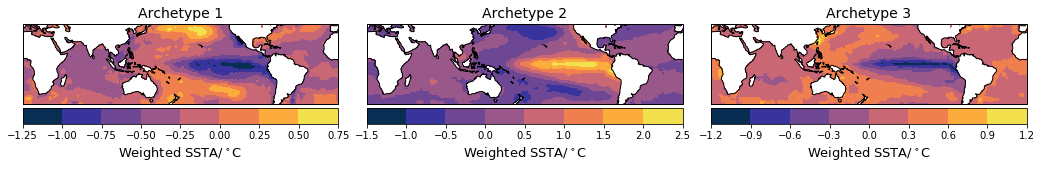

In [21]:
n_components = 3
output_file = get_aa_output_filename(SST_ANOM_INPUT_FILE, LAT_WEIGHTS, n_components, DELTA, N_INIT)

aa_ds = xr.open_dataset(output_file)

components = aa_ds['component'].values
n_samples = aa_ds.sizes[TIME_NAME]

projection = ccrs.PlateCarree(central_longitude=180)
wrap_lon = True

cmap = cmocean.cm.thermal

component_vmins = np.empty(n_components)
vmin = None
for i, component in enumerate(components):
    component_vmin = aa_ds['dictionary'].sel(component=component).min().item()
    if vmin is None or component_vmin < vmin:
        vmin = component_vmin

component_vmins[:] = vmin

component_vmaxs = np.empty(n_components)
vmax = None
for i, component in enumerate(components):
    component_vmax = aa_ds['dictionary'].sel(component=component).max().item()
    if vmax is None or component_vmax > vmax:
        vmax = component_vmax

component_vmaxs[:] = vmax

ncols = 2 if n_components % 2 == 0 else 3
nrows = int(np.ceil(n_components / ncols))
height_ratios = np.ones((nrows + 1))
height_ratios[-1] = 0.1

fig = plt.figure(constrained_layout=False, figsize=(6 * ncols, 3 * nrows))

gs = gridspec.GridSpec(ncols=ncols, nrows=nrows + 1, figure=fig,
                       wspace=0.09, hspace=0.12,
                       height_ratios=height_ratios)

lat = aa_ds[LAT_NAME]
lon = aa_ds[LON_NAME]

row_index = 0
col_index = 0
for i, component in enumerate(components):
    archetype_data = aa_ds['archetypes'].sel(component=component).values

    if wrap_lon:
        archetype_data, archetype_lon = add_cyclic_point(archetype_data, coord=lon)
    else:
        archetype_lon = lon

    lon_grid, lat_grid = np.meshgrid(archetype_lon, lat)

    ax = fig.add_subplot(gs[row_index, col_index], projection=projection)

    ax.coastlines()
    ax.set_global()

    ax_vmin = component_vmins[i]
    ax_vmax = component_vmaxs[i]

    cs = ax.contourf(lon_grid, lat_grid, archetype_data, # vmin=ax_vmin, vmax=ax_vmax,
                     cmap=cmap, transform=ccrs.PlateCarree())

    cb = fig.colorbar(cs, pad=0.03, orientation='horizontal')
    cb.set_label(r'Weighted SSTA/${}^\circ$C', fontsize=13)

    ax.set_ylim([MIN_LATITUDE, MAX_LATITUDE])

    ax.set_title('Archetype {}'.format(component + 1), fontsize=14)
    ax.set_aspect('equal')
    fig.canvas.draw()

    col_index += 1
    if col_index == ncols:
        col_index = 0
        row_index += 1

output_file = os.path.join(PLOTS_DIR, 'HadISST_sst.anom.{:d}_{:d}.trend_order{:d}.aa.{}.k{:d}.delta{:5.3e}.n_init{:d}.archetypes.unsorted.pdf'.format(
    BASE_PERIOD_START_YEAR, BASE_PERIOD_END_YEAR, ANOMALY_TREND_ORDER, LAT_WEIGHTS,
    n_components, DELTA, N_INIT))

plt.savefig(output_file, bbox_inches='tight')

plt.show()

plt.close()

aa_ds.close()

In [23]:
def to_1d_array(da):
    """Convert DataArray to flat array."""

    flat_data = np.ravel(da.values)

    missing_features = np.isnan(flat_data)

    return flat_data[np.logical_not(missing_features)]


def pattern_correlation(state, eof):
    """Calculate pattern correlation between state and EOF."""

    flat_state = to_1d_array(state)
    flat_eof = to_1d_array(eof)

    data = np.vstack([flat_state, flat_eof])

    r = np.corrcoef(data, rowvar=True)

    return r[0, 1]


def sort_states(ds, eofs_reference_file):
    """Sort states according to pattern correlation with EOFs."""

    n_components = ds.sizes['component']

    sort_order = []
    with xr.open_dataset(eofs_reference_file) as eofs_ds:

        n_eofs = eofs_ds.sizes['component']

        for i in range(n_eofs):
            correlations = np.empty((n_components,))

            for k in range(n_components):
                correlations[k] = pattern_correlation(
                    ds['archetypes'].sel(component=k),
                    eofs_ds['EOFs'].sel(component=i))

            ordering = np.argsort(-np.abs(correlations))
            for k in range(n_components):
                if ordering[k] not in sort_order:
                    sort_order.append(ordering[k])
                    break

            if np.size(sort_order) == n_components:
                break

    assert len(sort_order) <= n_components
    assert np.size(np.unique(sort_order)) == np.size(sort_order)

    if len(sort_order) < n_components:
        unassigned = [i for i in range(n_components) if i not in sort_order]
        sort_order += unassigned

    assert len(sort_order) == n_components
    assert np.size(np.unique(sort_order)) == np.size(sort_order)

    sorted_ds = xr.zeros_like(ds)
    for i in range(n_components):
        sorted_ds = xr.where(sorted_ds['component'] == i,
                             ds.sel(component=sort_order[i]), sorted_ds)

    for a in ds.attrs:
        sorted_ds.attrs[a] = ds.attrs[a]

    return sorted_ds

cos(theta) =  <xarray.DataArray ()>
array(0.93140398)
Coordinates:
    component  int32 0


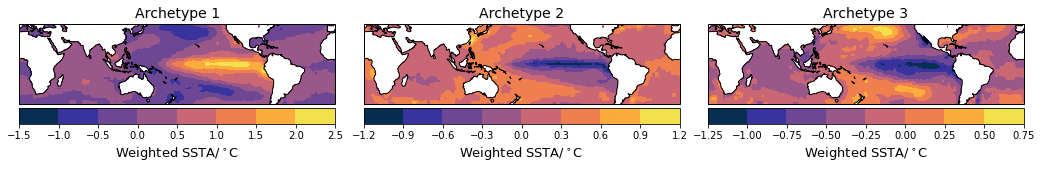

In [29]:
n_components = 3
output_file = get_aa_output_filename(SST_ANOM_INPUT_FILE, LAT_WEIGHTS, n_components, DELTA, N_INIT)

aa_ds = xr.open_dataset(output_file)

eofs_reference_file = os.path.join(RESULTS_DIR, 'HadISST_sst.anom.{:d}_{:d}.trend_order{:d}.pca.{}.k{:d}.nc'.format(
        BASE_PERIOD_START_YEAR, BASE_PERIOD_END_YEAR, ANOMALY_TREND_ORDER, LAT_WEIGHTS, n_components))

aa_ds = sort_states(aa_ds, eofs_reference_file)

# Calculate angle between leading principal axis and vector between first and second archetypes
if n_components > 1:
    with xr.open_dataset(eofs_reference_file) as eofs_ds:
        first_eof = eofs_ds['EOFs'].sel(component=0).squeeze().fillna(0)
        
        archetypes_difference = (aa_ds['archetypes'].sel(component=0) - aa_ds['archetypes'].sel(component=1)).squeeze().fillna(0)
        
        overlap = first_eof.dot(archetypes_difference) / np.sqrt(first_eof.dot(first_eof) * archetypes_difference.dot(archetypes_difference))
        
        print('cos(theta) = ', overlap)

components = aa_ds['component'].values
n_samples = aa_ds.sizes[TIME_NAME]

projection = ccrs.PlateCarree(central_longitude=180)
wrap_lon = True

cmap = cmocean.cm.thermal

component_vmins = np.empty(n_components)
vmin = None
for i, component in enumerate(components):
    component_vmin = aa_ds['archetypes'].sel(component=component).min().item()
    if vmin is None or component_vmin < vmin:
        vmin = component_vmin

component_vmins[:] = vmin

component_vmaxs = np.empty(n_components)
vmax = None
for i, component in enumerate(components):
    component_vmax = aa_ds['archetypes'].sel(component=component).max().item()
    if vmax is None or component_vmax > vmax:
        vmax = component_vmax

component_vmaxs[:] = vmax

ncols = 2 if n_components % 2 == 0 else 3
nrows = int(np.ceil(n_components / ncols))
height_ratios = np.ones((nrows + 1))
height_ratios[-1] = 0.1

fig = plt.figure(constrained_layout=False, figsize=(6 * ncols, 3 * nrows))

gs = gridspec.GridSpec(ncols=ncols, nrows=nrows + 1, figure=fig,
                       wspace=0.09, hspace=0.12,
                       height_ratios=height_ratios)

lat = aa_ds[LAT_NAME]
lon = aa_ds[LON_NAME]

row_index = 0
col_index = 0
for i, component in enumerate(components):
    archetype_data = aa_ds['archetypes'].sel(component=component).values

    if wrap_lon:
        archetype_data, archetype_lon = add_cyclic_point(archetype_data, coord=lon)
    else:
        archetype_lon = lon

    lon_grid, lat_grid = np.meshgrid(archetype_lon, lat)

    ax = fig.add_subplot(gs[row_index, col_index], projection=projection)

    ax.coastlines()
    ax.set_global()

    ax_vmin = component_vmins[i]
    ax_vmax = component_vmaxs[i]

    cs = ax.contourf(lon_grid, lat_grid, archetype_data, # vmin=ax_vmin, vmax=ax_vmax,
                     cmap=cmap, transform=ccrs.PlateCarree())

    cb = fig.colorbar(cs, pad=0.03, orientation='horizontal')
    cb.set_label(r'Weighted SSTA/${}^\circ$C', fontsize=13)

    ax.set_ylim([MIN_LATITUDE, MAX_LATITUDE])

    ax.set_title('Archetype {}'.format(component + 1), fontsize=14)
    ax.set_aspect('equal')
    fig.canvas.draw()

    col_index += 1
    if col_index == ncols:
        col_index = 0
        row_index += 1

output_file = os.path.join(PLOTS_DIR, 'HadISST_sst.anom.{:d}_{:d}.trend_order{:d}.aa.{}.k{:d}.delta{:5.3e}.n_init{:d}.archetypes.sorted.pdf'.format(
    BASE_PERIOD_START_YEAR, BASE_PERIOD_END_YEAR, ANOMALY_TREND_ORDER, LAT_WEIGHTS,
    n_components, DELTA, N_INIT))

plt.savefig(output_file, bbox_inches='tight')

plt.show()

plt.close()

aa_ds.close()

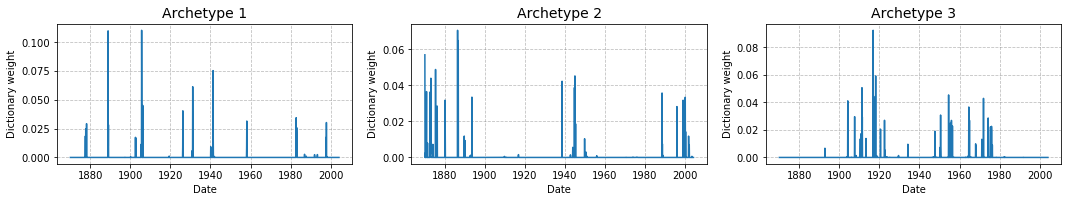

In [44]:
n_components = 3
output_file = get_aa_output_filename(SST_ANOM_INPUT_FILE, LAT_WEIGHTS, n_components, DELTA, N_INIT)

aa_ds = xr.open_dataset(output_file)

eofs_reference_file = os.path.join(RESULTS_DIR, 'HadISST_sst.anom.{:d}_{:d}.trend_order{:d}.pca.{}.k{:d}.nc'.format(
        BASE_PERIOD_START_YEAR, BASE_PERIOD_END_YEAR, ANOMALY_TREND_ORDER, LAT_WEIGHTS, n_components))

aa_ds = sort_states(aa_ds, eofs_reference_file)

ncols = 2 if n_components % 2 == 0 else 3
nrows = int(np.ceil(n_components / ncols))

fig = plt.figure(constrained_layout=False, figsize=(6 * ncols, 3 * nrows))

gs = gridspec.GridSpec(ncols=ncols, nrows=nrows + 1, figure=fig,
                       wspace=0.2, hspace=0.12,
                       height_ratios=height_ratios)

row_index = 0
col_index = 0
for i, component in enumerate(components):
    dictionary_data = aa_ds['dictionary'].sel(component=component).values

    ax = fig.add_subplot(gs[row_index, col_index])

    ax.plot(aa_ds[TIME_NAME], dictionary_data)
    ax.grid(ls='--', color='gray', alpha=0.5)

    ax.set_xlabel('Date')
    ax.set_ylabel('Dictionary weight')
    ax.set_title('Archetype {}'.format(component + 1), fontsize=14)

    col_index += 1
    if col_index == ncols:
        col_index = 0
        row_index += 1
        
plt.show()

plt.close()

aa_ds.close()

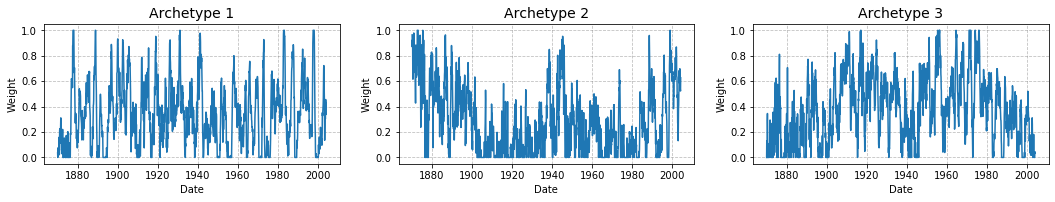

In [45]:
n_components = 3
output_file = get_aa_output_filename(SST_ANOM_INPUT_FILE, LAT_WEIGHTS, n_components, DELTA, N_INIT)

aa_ds = xr.open_dataset(output_file)

eofs_reference_file = os.path.join(RESULTS_DIR, 'HadISST_sst.anom.{:d}_{:d}.trend_order{:d}.pca.{}.k{:d}.nc'.format(
        BASE_PERIOD_START_YEAR, BASE_PERIOD_END_YEAR, ANOMALY_TREND_ORDER, LAT_WEIGHTS, n_components))

aa_ds = sort_states(aa_ds, eofs_reference_file)

ncols = 2 if n_components % 2 == 0 else 3
nrows = int(np.ceil(n_components / ncols))

fig = plt.figure(constrained_layout=False, figsize=(6 * ncols, 3 * nrows))

gs = gridspec.GridSpec(ncols=ncols, nrows=nrows + 1, figure=fig,
                       wspace=0.2, hspace=0.12,
                       height_ratios=height_ratios)

row_index = 0
col_index = 0
for i, component in enumerate(components):
    dictionary_data = aa_ds['weights'].sel(component=component).values

    ax = fig.add_subplot(gs[row_index, col_index])

    ax.plot(aa_ds[TIME_NAME], dictionary_data)
    ax.grid(ls='--', color='gray', alpha=0.5)

    ax.set_xlabel('Date')
    ax.set_ylabel('Weight')
    ax.set_title('Archetype {}'.format(component + 1), fontsize=14)

    col_index += 1
    if col_index == ncols:
        col_index = 0
        row_index += 1
        
plt.show()

plt.close()

aa_ds.close()

In [34]:
def get_latitude_weights(da, lat_weights='scos', lat_name=LAT_NAME):
    """Get latitude weights."""

    if lat_weights == 'cos':
        return np.cos(np.deg2rad(da[lat_name])).clip(0., 1.)

    if lat_weights == 'scos':
        return np.cos(np.deg2rad(da[lat_name])).clip(0., 1.) ** 0.5

    if lat_weights == 'none':
        return xr.ones_like(da[lat_name])

    raise ValueError("Invalid weights descriptor '%r'" % lat_weights)


def weight_and_flatten_data(da, weights=None, sample_dim=TIME_NAME):
    """Apply weighting to data and convert to 2D array."""

    feature_dims = [d for d in da.dims if d != sample_dim]
    original_shape = [da.sizes[d] for d in da.dims if d != sample_dim]

    if weights is not None:
        weighted_da = (weights * da).transpose(*da.dims)
    else:
        weighted_da = da

    if weighted_da.get_axis_num(sample_dim) != 0:
        weighted_da = weighted_da.transpose(*([sample_dim] + feature_dims))

    n_samples = weighted_da.sizes[sample_dim]
    n_features = np.product(original_shape)

    flat_data = weighted_da.data.reshape(n_samples, n_features)

    return flat_data


def run_mds(da, archetypes_da, n_components=2, lat_weights=LAT_WEIGHTS, metric=True,
            n_init=4, max_iter=300, verbose=0, eps=0.001, n_jobs=None,
            random_state=None, lat_name=LAT_NAME, sample_dim=TIME_NAME):
    """Run MDS on given data."""

    feature_dims = [d for d in da.dims if d != sample_dim]
    original_shape = [da.sizes[d] for d in da.dims if d != sample_dim]

    # Get requested latitude weights
    weights = get_latitude_weights(da, lat_weights=lat_weights,
                                   lat_name=lat_name)

    # Convert input data array to plain 2D array
    flat_data = weight_and_flatten_data(da, weights=weights, sample_dim=sample_dim)

    n_samples, n_features = flat_data.shape

    # Remove any features/columns with missing data
    missing_features = np.any(np.isnan(flat_data), axis=0)
    valid_data = flat_data[:, np.logical_not(missing_features)]
    
    # Add the climatological point for reference
    valid_data = np.vstack([valid_data, np.zeros(valid_data.shape[1])])
    
    # Append archetypes to data to be projected
    n_archetypes = archetypes_da.sizes['component']
    flat_archetypes = np.reshape(archetypes_da.values, (n_archetypes, n_features))
    valid_archetypes = flat_archetypes[:, np.logical_not(missing_features)]
    
    valid_data = np.vstack([valid_data, valid_archetypes])

    mds = MDS(n_components=n_components, metric=metric, n_init=n_init,
              max_iter=max_iter, verbose=verbose, eps=eps, n_jobs=n_jobs,
              random_state=random_state, dissimilarity='euclidean').fit(valid_data)
    
    embedding_da = xr.DataArray(
        mds.embedding_[:n_samples],
        coords={sample_dim: da[sample_dim], 'component': np.arange(n_components)},
        dims=[sample_dim, 'component'])
    origin_da = xr.DataArray(
        mds.embedding_[n_samples],
        coords={'component': np.arange(n_components)},
        dims=['component'])
    archetypes_embed_da = xr.DataArray(
        mds.embedding_[n_samples + 1:],
        coords={'archetype': np.arange(archetypes_da.sizes['component']), 'component': np.arange(n_components)},
        dims=['archetype', 'component'])
    
    mds_ds = xr.Dataset(data_vars={'embedding': embedding_da, 'origin': origin_da, 'archetypes': archetypes_embed_da})
    mds_ds.attrs['stress'] = '{:16.8e}'.format(mds.stress_)

    return mds_ds

In [31]:
sst_anom_ds = xr.open_dataset(SST_ANOM_INPUT_FILE)

sst_anom_ds = sst_anom_ds.where(
    (sst_anom_ds[TIME_NAME].dt.year >= START_YEAR) &
    (sst_anom_ds[TIME_NAME].dt.year <= END_YEAR), drop=True)

sst_anom_ds = sst_anom_ds.where(
    (sst_anom_ds[LAT_NAME] >= MIN_LATITUDE) &
    (sst_anom_ds[LAT_NAME] <= MAX_LATITUDE), drop=True)

sst_anom_da = sst_anom_ds[ANOMALY_NAME]

if RESTRICT_TO_CLIMATOLOGY_BASE_PERIOD:
    clim_base_period = [int(sst_anom_ds.attrs['base_period_start_year']),
                            int(sst_anom_ds.attrs['base_period_end_year'])]

    sst_anom_da = sst_anom_da.where(
        (sst_anom_da[TIME_NAME].dt.year >= clim_base_period[0]) &
        (sst_anom_da[TIME_NAME].dt.year <= clim_base_period[1]), drop=True)

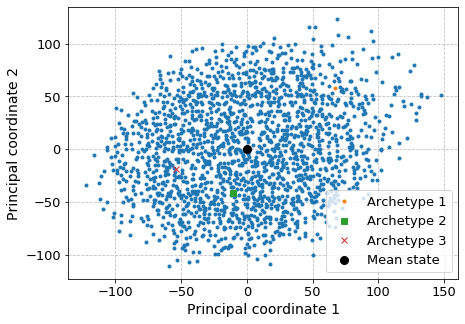

In [67]:
n_components = 3
output_file = get_aa_output_filename(SST_ANOM_INPUT_FILE, LAT_WEIGHTS, n_components, DELTA, N_INIT)

aa_ds = xr.open_dataset(output_file)

eofs_reference_file = os.path.join(RESULTS_DIR, 'HadISST_sst.anom.{:d}_{:d}.trend_order{:d}.pca.{}.k{:d}.nc'.format(
        BASE_PERIOD_START_YEAR, BASE_PERIOD_END_YEAR, ANOMALY_TREND_ORDER, LAT_WEIGHTS, n_components))

aa_ds = sort_states(aa_ds, eofs_reference_file)

mds_2d_scos = run_mds(sst_anom_da, aa_ds['archetypes'], n_components=2, lat_weights='scos', random_state=0)

n_samples = aa_ds.sizes[TIME_NAME]

fig = plt.figure(figsize=(7, 5))
ax = plt.gca()

ax.plot(mds_2d_scos['embedding'].sel(component=0), mds_2d_scos['embedding'].sel(component=1), '.')

markers = itertools.cycle(('.', 's', 'x', 'o', '+'))
for i in range(n_components):
    
    ax.plot(mds_2d_scos['archetypes'].sel(archetype=i, component=0),
            mds_2d_scos['archetypes'].sel(archetype=i, component=1),
            marker=next(markers), ls='none',
            label='Archetype {:d}'.format(i + 1))

ax.plot(mds_2d_scos['origin'].sel(component=0), mds_2d_scos['origin'].sel(component=1), 'ko', markersize=8,
        label='Mean state')

ax.grid(ls='--', color='gray', alpha=0.5)
ax.legend(fontsize=13)

ax.set_xlabel('Principal coordinate 1', fontsize=14)
ax.set_ylabel('Principal coordinate 2', fontsize=14)
ax.axes.tick_params(labelsize=13)

output_file = os.path.join(PLOTS_DIR, 'HadISST_sst.anom.{:d}_{:d}.trend_order{:d}.aa.{}.k{:d}.delta{:5.3e}.n_init{:d}.mds.pdf'.format(
    BASE_PERIOD_START_YEAR, BASE_PERIOD_END_YEAR, ANOMALY_TREND_ORDER, LAT_WEIGHTS,
    n_components, DELTA, N_INIT))

plt.savefig(output_file, bbox_inches='tight')

plt.show()

plt.close()

aa_ds.close()

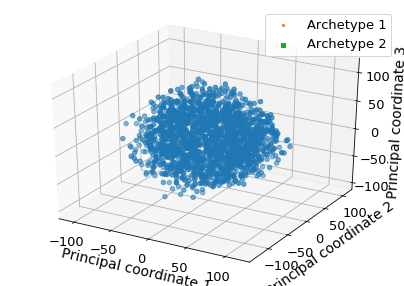

In [66]:
n_components = 2
output_file = get_aa_output_filename(SST_ANOM_INPUT_FILE, LAT_WEIGHTS, n_components, DELTA, N_INIT)

aa_ds = xr.open_dataset(output_file)

eofs_reference_file = os.path.join(RESULTS_DIR, 'HadISST_sst.anom.{:d}_{:d}.trend_order{:d}.pca.{}.k{:d}.nc'.format(
        BASE_PERIOD_START_YEAR, BASE_PERIOD_END_YEAR, ANOMALY_TREND_ORDER, LAT_WEIGHTS, n_components))

aa_ds = sort_states(aa_ds, eofs_reference_file)

mds_3d_scos = run_mds(sst_anom_da, aa_ds['archetypes'], n_components=3, lat_weights='scos', random_state=0)

n_samples = aa_ds.sizes[TIME_NAME]

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(mds_3d_scos['embedding'].sel(component=0), mds_3d_scos['embedding'].sel(component=1),
           mds_3d_scos['embedding'].sel(component=2), '.')

markers = itertools.cycle(('.', 's', 'x', 'o', '+'))
for i in range(n_components):
    
    ax.scatter(mds_3d_scos['archetypes'].sel(archetype=i, component=0),
               mds_3d_scos['archetypes'].sel(archetype=i, component=1),
               mds_3d_scos['archetypes'].sel(archetype=i, component=2),
               marker=next(markers),
               label='Archetype {:d}'.format(i + 1))

#ax.plot(mds_2d_scos['origin'].sel(component=0), mds_2d_scos['origin'].sel(component=1), 'ko', markersize=8,
#        label='Mean state')

ax.grid(ls='--', color='gray', alpha=0.5)
ax.legend(fontsize=13)

ax.set_xlabel('Principal coordinate 1', fontsize=14)
ax.set_ylabel('Principal coordinate 2', fontsize=14)
ax.set_zlabel('Principal coordinate 3', fontsize=14)
ax.axes.tick_params(labelsize=13)

#output_file = os.path.join(PLOTS_DIR, 'HadISST_sst.anom.{:d}_{:d}.trend_order{:d}.aa.{}.k{:d}.delta{:5.3e}.n_init{:d}.mds.pdf'.format(
#    BASE_PERIOD_START_YEAR, BASE_PERIOD_END_YEAR, ANOMALY_TREND_ORDER, LAT_WEIGHTS,
#    n_components, DELTA, N_INIT))

#plt.savefig(output_file, bbox_inches='tight')

plt.show()

plt.close()

aa_ds.close()

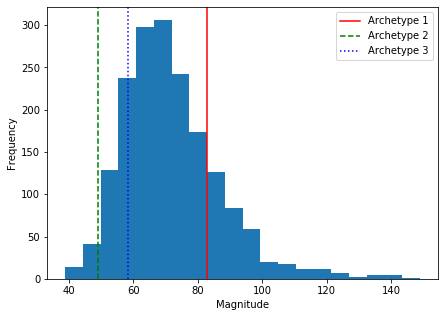

In [68]:
scos_weights = get_latitude_weights(sst_anom_da, lat_weights='scos')

flat_sst_anom_scos = weight_and_flatten_data(sst_anom_da, weights=scos_weights)

missing_features = np.any(np.isnan(flat_sst_anom_scos), axis=0)
valid_sst_anom_scos = flat_sst_anom_scos[:, np.logical_not(missing_features)]

magnitudes = np.linalg.norm(valid_sst_anom_scos, axis=1)

n_components = 3
output_file = get_aa_output_filename(SST_ANOM_INPUT_FILE, LAT_WEIGHTS, n_components, DELTA, N_INIT)

aa_ds = xr.open_dataset(output_file)

eofs_reference_file = os.path.join(RESULTS_DIR, 'HadISST_sst.anom.{:d}_{:d}.trend_order{:d}.pca.{}.k{:d}.nc'.format(
        BASE_PERIOD_START_YEAR, BASE_PERIOD_END_YEAR, ANOMALY_TREND_ORDER, LAT_WEIGHTS, n_components))

aa_ds = sort_states(aa_ds, eofs_reference_file)

archetype_magnitudes = np.zeros(n_components)
for i in range(n_components):
    archetype = aa_ds['archetypes'].sel(component=i).fillna(0)
    archetype_magnitudes[i] = archetype.dot(archetype) ** 0.5

fig = plt.figure(figsize=(7, 5))
ax = plt.gca()

ax.hist(magnitudes, bins=20)

linestyles = itertools.cycle(('-', '--', ':', '-.'))
colors = itertools.cycle(('red', 'green', 'blue'))
for i in range(n_components):
    ax.axvline(archetype_magnitudes[i], color=next(colors), ls=next(linestyles),
               label='Archetype {:d}'.format(i + 1))

ax.legend()

ax.set_xlabel('Magnitude')
ax.set_ylabel('Frequency')

plt.show()

plt.close()

In [121]:
def simplex_plot(da, weights_da, archetypes_da,  sample_dim=TIME_NAME):

    feature_dims = [d for d in da.dims if d != sample_dim]
    original_shape = [da.sizes[d] for d in da.dims if d != sample_dim]

    reconstruction = weights_da.dot(archetypes_da)
    
    residuals = weight_and_flatten_data((da - reconstruction).fillna(0), sample_dim=sample_dim)
    magnitudes = np.linalg.norm(residuals, axis=1)
    
    n_components = archetypes_da.sizes['component']
    archetype_coords = np.zeros((n_components, 2))
    for i in range(n_components):
        archetype_coords[i, 0] = np.cos(2 * pi * (i + 1) / n_components)
        archetype_coords[i, 1] = np.sin(2 * pi * (i + 1) / n_components)

    sample_weights = weight_and_flatten_data(weights_da, sample_dim=sample_dim)

    sample_coords = sample_weights.dot(archetype_coords)
    
    fig = plt.figure(figsize=(7, 5))
    ax = plt.gca()
    
    ax.plot(archetype_coords[:, 0], archetype_coords[:, 1], 'ko', ls='-')
    
    cs = ax.scatter(sample_coords[:, 0], sample_coords[:, 1], c=magnitudes, alpha=0.75)
    
    cb = plt.colorbar(cs)
    
    ax.axes.tick_params(tick1On=False, tick2On=False)
    
    plt.show()
    
    plt.close()

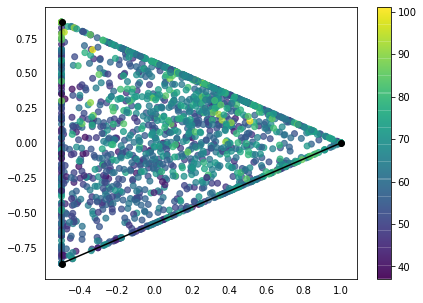

In [123]:
n_components = 3
output_file = get_aa_output_filename(SST_ANOM_INPUT_FILE, LAT_WEIGHTS, n_components, DELTA, N_INIT)

aa_ds = xr.open_dataset(output_file)

eofs_reference_file = os.path.join(RESULTS_DIR, 'HadISST_sst.anom.{:d}_{:d}.trend_order{:d}.pca.{}.k{:d}.nc'.format(
        BASE_PERIOD_START_YEAR, BASE_PERIOD_END_YEAR, ANOMALY_TREND_ORDER, LAT_WEIGHTS, n_components))

aa_ds = sort_states(aa_ds, eofs_reference_file)

sst_anom_scos_da = (scos_weights * sst_anom_da).transpose(*sst_anom_da.dims)

simplex_plot(sst_anom_scos_da, aa_ds['weights'], aa_ds['archetypes'])